In [1]:
import tensorflow as tf

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

import keras.backend as K
#import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
df = pd.read_csv('data/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')
df = df[df.label_name == 'coat_length']

display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
10,Images/coat_length_labels/615df9444a10e7e7856d...,coat_length,nnnnnynn
27,Images/coat_length_labels/294e95a3241e4369b230...,coat_length,nynnnnnn
29,Images/coat_length_labels/b01c904a3a4b5b18a41a...,coat_length,nnnynnnn
34,Images/coat_length_labels/025dd3083efb06e6be5a...,coat_length,nnnnynnn
36,Images/coat_length_labels/0aea2497f2d72364b91e...,coat_length,nnnnnynn


Counter({'coat_length': 11320})

In [5]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'coat_length': 8}

In [6]:
n = len(df)
print(n)

11320


In [7]:
fnames = df['filename'].values
width = 399

y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
df = df.reset_index(drop=True)

In [8]:
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1
    #y[label_names.index(label_name)][i, label.find('m')] = 0.5

In [9]:
print(fnames[0:10])
print(n)
print(len(y[0]))
print(len(y))
print(label_count.keys())
print(len(y[0][0]))

['Images/coat_length_labels/615df9444a10e7e7856dc19b70eed8f2.jpg'
 'Images/coat_length_labels/294e95a3241e4369b230da4e2a39172c.jpg'
 'Images/coat_length_labels/b01c904a3a4b5b18a41a9940a8c44eae.jpg'
 'Images/coat_length_labels/025dd3083efb06e6be5a421d07612a5d.jpg'
 'Images/coat_length_labels/0aea2497f2d72364b91e8cb1d0d64ed4.jpg'
 'Images/coat_length_labels/181ad8b58e6b94c253ac413e66af43b7.jpg'
 'Images/coat_length_labels/e14abec52f582d76e76c9723574ff9ad.jpg'
 'Images/coat_length_labels/3242fc9ce9bf86c3877ab0b4d5fbc725.jpg'
 'Images/coat_length_labels/0103527345c45e034ba53e16d6ff397b.jpg'
 'Images/coat_length_labels/8a1cf8ab3925b245736dd42261b3313a.jpg']
11320
11320
1
dict_keys(['coat_length'])
8


In [10]:
def f(index):
    if os.path.isfile('data/'+fnames[index]):
        return index, cv2.resize(cv2.imread('data/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 11320/11320 [00:20<00:00, 560.07it/s]


In [11]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [12]:
from dataset import *
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

In [13]:
base_model = ResNet50(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

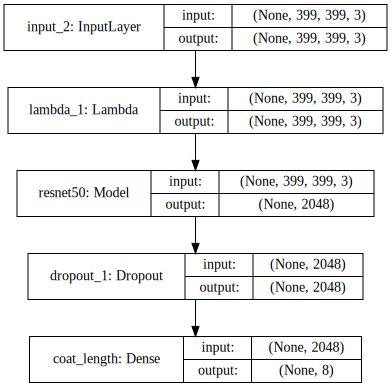

In [14]:
input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_coat_length.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model2 = multi_gpu_model(model, n_gpus)

In [16]:
model2.compile(optimizer = Adam(0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=8, validation_data=(X_valid, y_valid))

Epoch 1/8
284/284 [==============================] - 377s 1s/step - loss: 1.1109 - acc: 0.5846 - val_loss: 0.6137 - val_acc: 0.7818
Epoch 2/8
284/284 [==============================] - 338s 1s/step - loss: 0.6181 - acc: 0.7782 - val_loss: 0.6808 - val_acc: 0.7959
Epoch 3/8
284/284 [==============================] - 333s 1s/step - loss: 0.4718 - acc: 0.8311 - val_loss: 0.4741 - val_acc: 0.8352
Epoch 4/8
284/284 [==============================] - 340s 1s/step - loss: 0.3820 - acc: 0.8622 - val_loss: 0.6519 - val_acc: 0.7911
Epoch 5/8
284/284 [==============================] - 337s 1s/step - loss: 0.3220 - acc: 0.8863 - val_loss: 0.5832 - val_acc: 0.8211
Epoch 6/8
284/284 [==============================] - 339s 1s/step - loss: 0.2716 - acc: 0.9081 - val_loss: 0.6654 - val_acc: 0.8008
Epoch 7/8
284/284 [==============================] - 341s 1s/step - loss: 0.2424 - acc: 0.9140 - val_loss: 0.6750 - val_acc: 0.8004
Epoch 8/8
284/284 [==============================] - 341s 1s/step - loss: 0.

In [17]:
model2.compile(optimizer = Adam(0.000025),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
284/284 [==============================] - 373s 1s/step - loss: 0.1295 - acc: 0.9565 - val_loss: 0.4222 - val_acc: 0.8715
Epoch 2/3
284/284 [==============================] - 334s 1s/step - loss: 0.0910 - acc: 0.9691 - val_loss: 0.4491 - val_acc: 0.8715
Epoch 3/3
284/284 [==============================] - 335s 1s/step - loss: 0.0689 - acc: 0.9788 - val_loss: 0.5155 - val_acc: 0.8657


In [18]:
model2.compile(optimizer = Adam(0.00000625),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
284/284 [==============================] - 376s 1s/step - loss: 0.0536 - acc: 0.9831 - val_loss: 0.4515 - val_acc: 0.8803
Epoch 2/3
284/284 [==============================] - 330s 1s/step - loss: 0.0506 - acc: 0.9845 - val_loss: 0.4500 - val_acc: 0.8812
Epoch 3/3
284/284 [==============================] - 340s 1s/step - loss: 0.0446 - acc: 0.9870 - val_loss: 0.4506 - val_acc: 0.8803


In [19]:
model2.compile(optimizer = Adam(0.00000425),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
284/284 [==============================] - 380s 1s/step - loss: 0.0402 - acc: 0.9888 - val_loss: 0.4663 - val_acc: 0.8785


In [20]:
model2.compile(optimizer = Adam(0.000001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
284/284 [==============================] - 384s 1s/step - loss: 0.0385 - acc: 0.9895 - val_loss: 0.4477 - val_acc: 0.8825


In [21]:
model_name = 'resnet_coat_length'

model.save('model_%s.h5' % model_name)